# I. Loading data

In [11]:
with open('temples.txt',encoding='utf-8') as file:
  data=file.read()
print(data[:100])

ប្រាសាទអង្គរវត្ត ឬប្រាសាទអង្គរតូចមានទីតាំងស្ថិតនៅភាគខាងជើងនៃក្រុងសៀមរាបនៃខេត្តសៀមរាប។ ប្រាសាទអង្គរវត


## 1. Preprocessing

In [10]:
import khmernltk
from khmernltk import word_tokenize
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
cleaned_data=re.sub(r"[()+#។—\"\-\[\]:... ]","",data)
tokens=word_tokenize(cleaned_data)
word_counts = Counter(tokens)
word_counts.most_common(10)

[('និង', 226),
 ('ដែល', 198),
 ('ប្រាសាទ', 196),
 ('មាន', 165),
 ('នៅ', 156),
 ('បាន', 155),
 ('នៃ', 153),
 ('នេះ', 135),
 ('ជា', 112),
 ('ត្រូវបាន', 91)]

## 2. Word with frequency equal to and  more than 10 

In [4]:
sentence=[]
for k, v in enumerate(word_counts.items()):
    if v[1]>=10:
      sentence.append(v[0])

## 3. Skip-Gram with dimension of 50, window size L={-4,+4} and nagative sampling with k=2

In [5]:
from gensim.models import Word2Vec
sentences = [sentence] 

# Train Word2Vec with Skip-Gram architecture
model = Word2Vec(
    sentences,
    vector_size=50,  # Embedding dimension
    window=4,        # Context window size L = {-4,+4}
    sg=1,            # Use Skip-Gram (sg=1), CBOW (sg=0)
    negative=2,      # Negative sampling with k=2
    min_count=1,     # Include all words, regardless of frequency
    workers=4        # Number of CPU cores for training
)

# Save the trained embeddings
model.save("khmer_word_embeddings.model")

# Example: Find similar words
word = "ប្រាសាទ"
if word in model.wv:
    print(f"Embedding for '{word}':\n{model.wv[word]}")
similar_words = model.wv.most_similar("ប្រាសាទ", topn=5)
print(f"Words similar to 'ប្រាសាទ':\n{similar_words}")

Embedding for 'ប្រាសាទ':
[-0.01485762  0.00077397  0.00165361  0.00126593  0.01567015 -0.00395403
 -0.01896889  0.01198811  0.01555519 -0.01186924  0.01606816  0.01015874
 -0.00491284 -0.0034291   0.01263838  0.01614733  0.01714538 -0.01386919
  0.00064618 -0.01087981 -0.01865497 -0.00685122 -0.00651833 -0.01166538
  0.00643052 -0.00782603  0.0006791  -0.00460523  0.00419401  0.01107939
  0.01996287  0.00776671 -0.00821222  0.01132412  0.00921542  0.00199565
  0.01963717 -0.00833643  0.00974555 -0.01425382  0.00902467  0.01810426
 -0.0165816   0.00504331  0.01159379 -0.01161275 -0.01425933 -0.0077446
  0.00747941  0.00286956]
Words similar to 'ប្រាសាទ':
[('តែ', 0.3942500650882721), ('ទេសចរណ៍', 0.3336293697357178), ('ចម្លាក់', 0.30533450841903687), ('លក្ខណៈ', 0.299923837184906), ('ដ៏', 0.2975347638130188)]


# II. Applied PCA

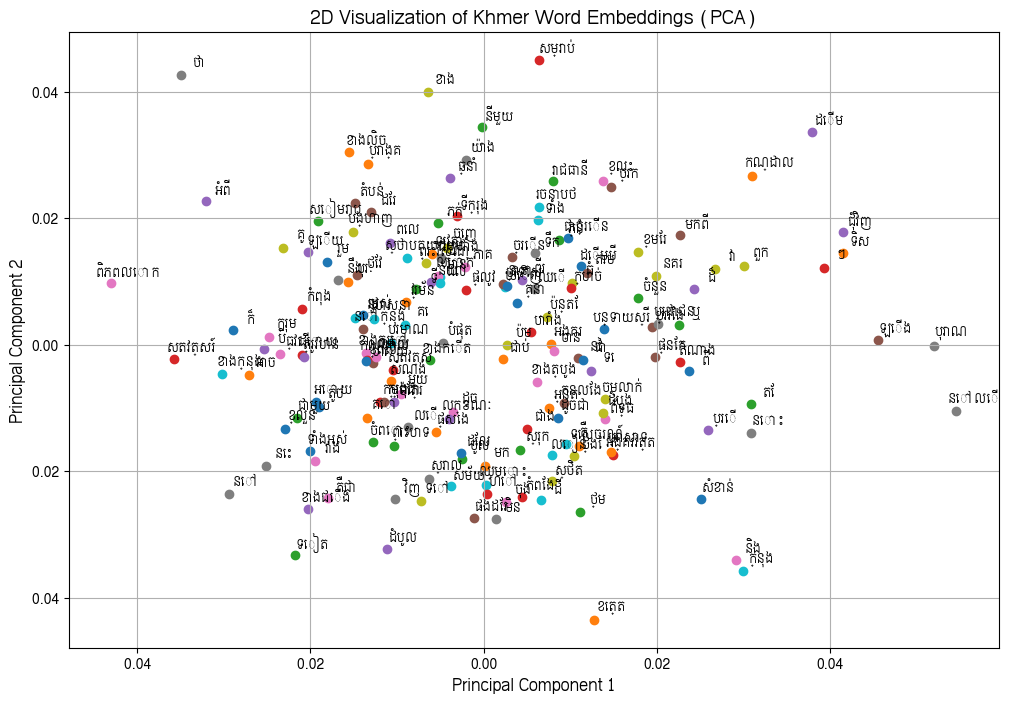

In [25]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.font_manager as fm

khmer_font_path = "KhmerOS_siemreap.ttf" 
khmer_font = fm.FontProperties(fname=khmer_font_path, size=9)

# Extract all word embeddings from the model
word_vectors = model.wv.vectors
words = model.wv.index_to_key

# Apply PCA to reduce dimensions from 50 to 2
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

# Plot the 2D word embeddings
plt.figure(figsize=(12, 8))
for i, word in enumerate(words):
    # plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1], marker='o', color='blue')
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1], marker='o')
    plt.text(
        word_vectors_2d[i, 0] + 0.002,  # Offset to avoid overlapping
        word_vectors_2d[i, 1] + 0.002,
        word,
        fontproperties=khmer_font,
        fontsize=9,
        horizontalalignment='center', 
        verticalalignment='center'
    )
plt.title('2D Visualization of Khmer Word Embeddings (PCA)', fontproperties=khmer_font, fontsize=14)
plt.xlabel('Principal Component 1', fontproperties=khmer_font, fontsize=12)
plt.ylabel('Principal Component 2', fontproperties=khmer_font, fontsize=12)
plt.grid(True)
plt.show()


## Plot with most 50 words

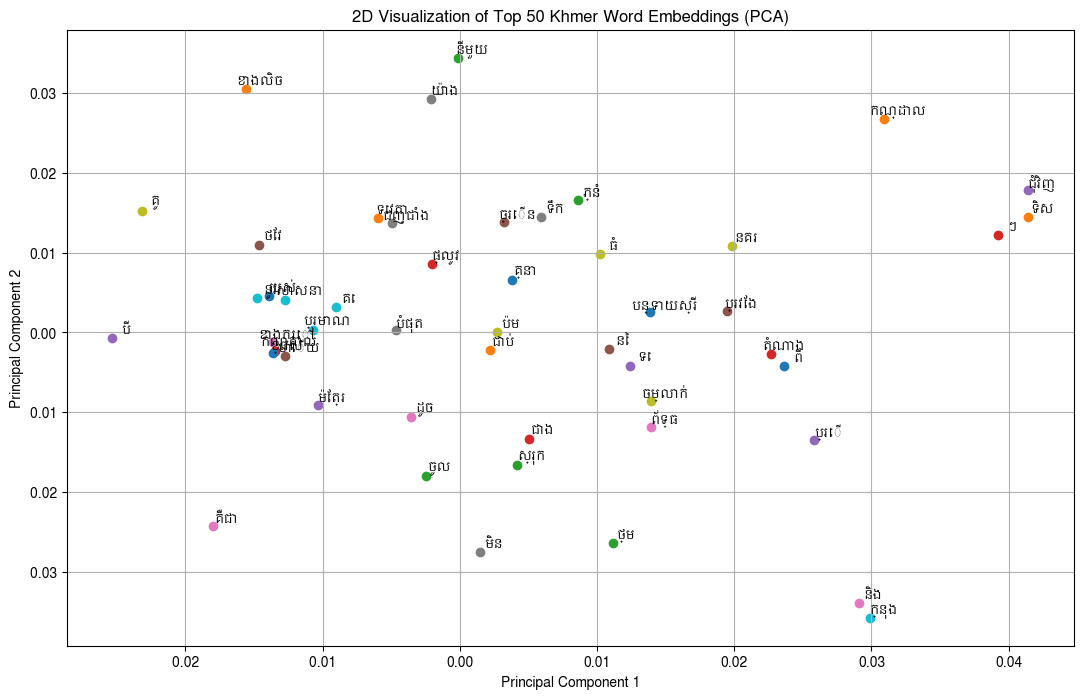

In [29]:
# Plot only the top 50 most frequent words
plt.figure(figsize=(13, 8))
for i, word in enumerate(words[:50]):  # Top 50 words
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1], marker='o')
    plt.text(word_vectors_2d[i, 0] + 0.001, word_vectors_2d[i, 1] + 0.001, word, fontsize=9,horizontalalignment='center', verticalalignment='center')

plt.title('2D Visualization of Top 50 Khmer Word Embeddings (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


# III. Natural Language processing predict next word

In [37]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare data for next-word prediction
sequence_length = 5  # N = 5
vocab_size = len(model.wv.index_to_key)
word_to_index = {word: idx for idx, word in enumerate(model.wv.index_to_key)}
index_to_word = {idx: word for word, idx in word_to_index.items()}

# Create sequences of N words and the next word as target
input_sequences = []
target_words = []
for i in range(len(tokens) - sequence_length):
    input_seq = tokens[i:i + sequence_length]
    target_word = tokens[i + sequence_length]
    if all(word in word_to_index for word in input_seq + [target_word]):
        input_sequences.append([word_to_index[word] for word in input_seq])
        target_words.append(word_to_index[target_word])

input_sequences = np.array(input_sequences)
target_words = np.array(target_words)

# One-hot encode the target words
y = to_categorical(target_words, num_classes=vocab_size)

# Build the Neural Language Model
model_next_word = Sequential([
    Embedding(input_dim=vocab_size, output_dim=50, weights=[model.wv.vectors], input_length=sequence_length, trainable=False),
    LSTM(512),
    Dense(vocab_size, activation='softmax')
])

model_next_word.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_next_word.fit(input_sequences, y, epochs=100, batch_size=64)

# Save the trained model
model_next_word.save("khmer_next_word_prediction.h5")

# Predict the next word for a given input sequence
def predict_next_word(input_text):
    input_tokens = [word_to_index[word] for word in input_text if word in word_to_index]
    if len(input_tokens) < sequence_length:
        input_tokens = [0] * (sequence_length - len(input_tokens)) + input_tokens
    input_tokens = np.array(input_tokens[-sequence_length:]).reshape(1, -1)
    prediction = model_next_word.predict(input_tokens, verbose=0)
    predicted_index = np.argmax(prediction)
    return index_to_word[predicted_index]

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.0493 - loss: 5.1440
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0734 - loss: 5.0981
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0646 - loss: 4.8002
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0521 - loss: 4.5690
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0504 - loss: 4.4412
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0562 - loss: 4.4142
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0627 - loss: 4.3910
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0610 - loss: 4.4218
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0563 - loss: 4.4142
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0488 - loss: 4.4117
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0572 - loss: 4.3805
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0453 - lo

In [38]:
# Example
test_sequence = ["ប្រាសាទ", "នៅ", "កម្ពុជា", "មាន", "ច្រើន"]
predicted_word = predict_next_word(test_sequence)
print(f"Next word prediction for {test_sequence}: {predicted_word}")

Next word prediction for ['ប្រាសាទ', 'នៅ', 'កម្ពុជា', 'មាន', 'ច្រើន']: ច្រើន


# IV. Compare for Natural Language model that learned from scratch and the model using  Word2Vec

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Build the modified Neural Language Model with trainable embeddings
vocab_size = len(word_to_index)  # Same vocabulary size as before
embedding_dim = 50  # Embedding dimension

model_from_scratch = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length, trainable=True),
    LSTM(512),
    Dense(vocab_size, activation='softmax')
])

model_from_scratch.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_from_scratch.fit(input_sequences, y, epochs=100, batch_size=64)

# Extract learned embeddings from the embedding layer
embedding_layer = model_from_scratch.layers[0]
learned_embeddings = embedding_layer.get_weights()[0]  # Shape: (vocab_size, embedding_dim)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.0278 - loss: 5.1438
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0650 - loss: 5.0958
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.0536 - loss: 4.8077
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0563 - loss: 4.5558
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0837 - loss: 4.4791
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0575 - loss: 4.4355
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0634 - loss: 4.3303
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0701 - loss: 4.3038
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0607 - loss: 4.2283
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.0701 - loss: 4.2227
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0958 - loss: 4.1370
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0826 - lo

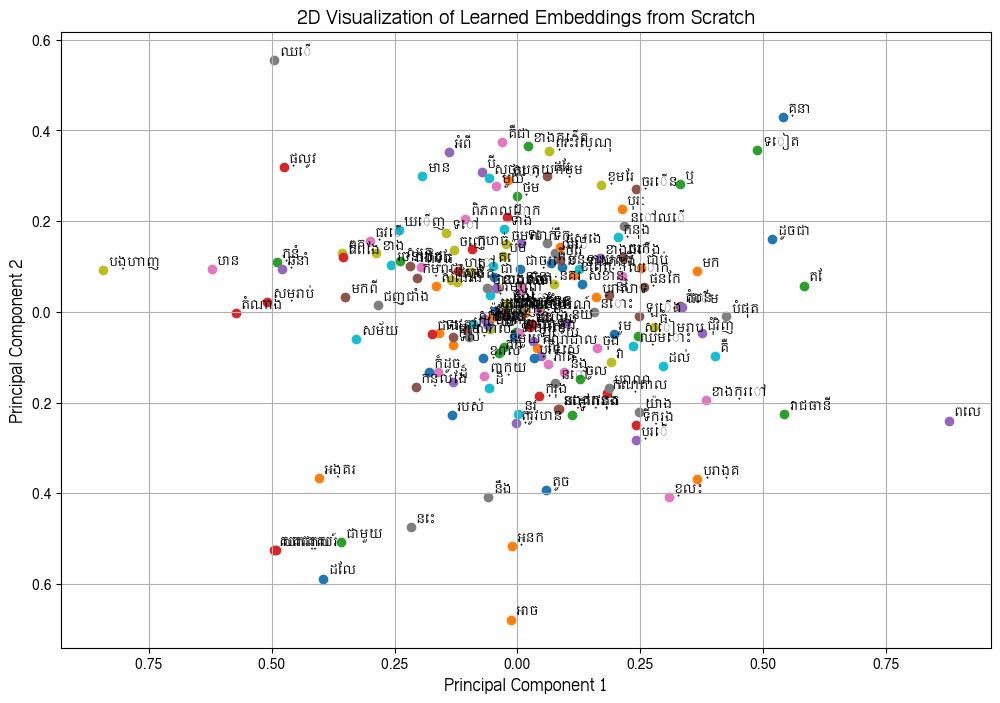

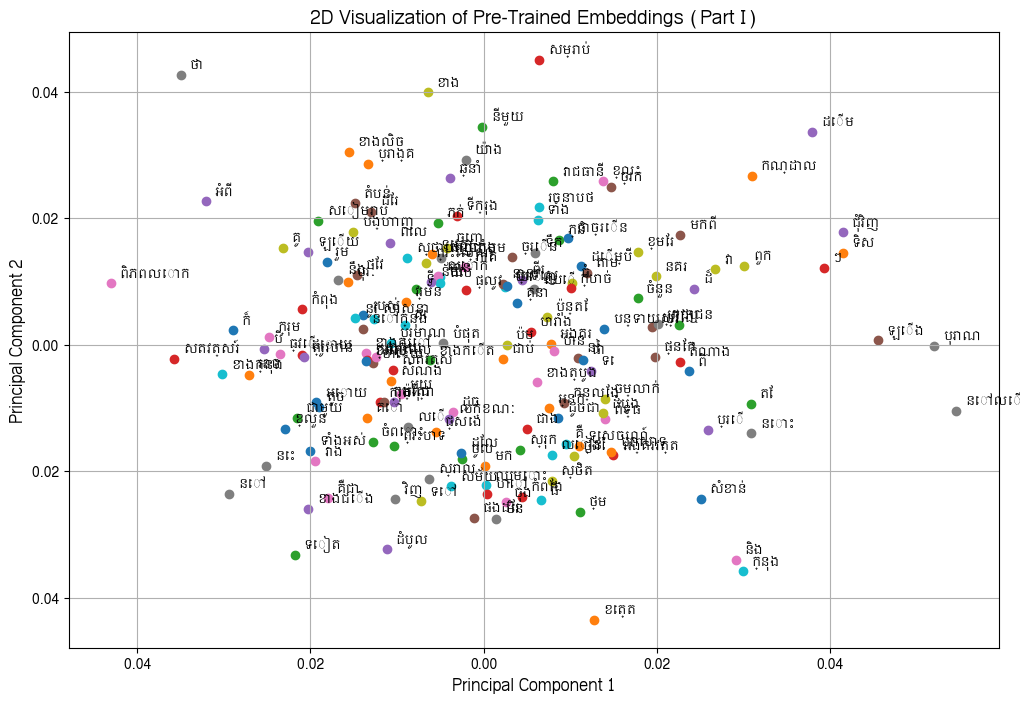

In [51]:
khmer_font_path = "KhmerOS_siemreap.ttf" 
khmer_font = fm.FontProperties(fname=khmer_font_path, size=9)

# Apply PCA to reduce dimensions from 50 to 2
pca_from_scratch = PCA(n_components=2)
embeddings_2d_from_scratch = pca_from_scratch.fit_transform(learned_embeddings)

# Visualize the learned embeddings
plt.figure(figsize=(12, 8))
for i, word in enumerate(word_to_index.keys()):
    plt.scatter(embeddings_2d_from_scratch[i, 0], embeddings_2d_from_scratch[i, 1], marker='o')
    plt.text(embeddings_2d_from_scratch[i, 0] + 0.01, embeddings_2d_from_scratch[i, 1] + 0.01, word, fontsize=9)

plt.title('2D Visualization of Learned Embeddings from Scratch', fontproperties=khmer_font, fontsize=14)
plt.xlabel('Principal Component 1', fontproperties=khmer_font, fontsize=12)
plt.ylabel('Principal Component 2', fontproperties=khmer_font, fontsize=12)
plt.grid(True)
plt.show()


# Comparison with Pre-Trained Embeddings
pca_pretrained = PCA(n_components=2)
embeddings_2d_pretrained = pca_pretrained.fit_transform(model.wv.vectors)

# Plot Pre-Trained Embeddings
plt.figure(figsize=(12, 8))
for i, word in enumerate(word_to_index.keys()):
    plt.scatter(embeddings_2d_pretrained[i, 0], embeddings_2d_pretrained[i, 1], marker='o')
    plt.text(embeddings_2d_pretrained[i, 0] + 0.001, embeddings_2d_pretrained[i, 1] + 0.001, word, fontsize=9)

plt.title('2D Visualization of Pre-Trained Embeddings (Part I)', fontproperties=khmer_font, fontsize=14)
plt.xlabel('Principal Component 1', fontproperties=khmer_font, fontsize=12)
plt.ylabel('Principal Component 2', fontproperties=khmer_font, fontsize=12)
plt.grid(True)
plt.show()